# Homework 1 - Programming Section Notebook

## Context
Given a dataset of 768 patients showcasing different biological features which may indicate diabetes, we must classify the patients into 2 classes: normal or diabetes

In [62]:
from scipy.io import arff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


dataset_file_path = "diabetes.arff"

data, meta_data = arff.loadarff(dataset_file_path)

data = pd.DataFrame(data)
data["Outcome"] = data["Outcome"].astype(int)


n_features = data.columns.size - 1          
n_dataset_entries = data.index.size
n_classes = len(data["Outcome"].unique())

#data.isnull().sum() #Every dataset field is filled, therefore no need for data imputation

## 1 - Identify discriminative power of provided features

In [122]:
from sklearn.feature_selection import f_classif 

X = data.drop("Outcome",axis=1) #Sample*Features Matrix
y = data["Outcome"] #Sample*Targets Vector

fstatistics = f_classif(X,y)

max_discriminative_power_feature_index = 0
min_discriminative_power_feature_index = 0

for i in range(n_features):
    print("\'" + X.columns.values[i] + "\': " + str(round(fstatistics[0][i],2)))

    if i > 0 and fstatistics[0][i] > fstatistics[0][max_discriminative_power_feature_index]:
        max_discriminative_power_feature_index = i

    if i > 0 and fstatistics[0][i] < fstatistics[0][min_discriminative_power_feature_index]:
        min_discriminative_power_feature_index = i

print("\nThe most discriminative features is \'" + X.columns.values[max_discriminative_power_feature_index] + "\' with a discriminative power of " + str(fstatistics[0][max_discriminative_power_feature_index]))

print("The least discriminative features is \'" + X.columns.values[min_discriminative_power_feature_index] + "\' with a discriminative power of " + str(fstatistics[0][min_discriminative_power_feature_index]))

'Pregnancies': 39.67
'Glucose': 213.16
'BloodPressure': 3.26
'SkinThickness': 4.3
'Insulin': 13.28
'BMI': 71.77
'DiabetesPedigreeFunction': 23.87
'Age': 46.14

The most discriminative features is 'Glucose' with a discriminative power of 213.16175217803828
The least discriminative features is 'BloodPressure' with a discriminative power of 3.256950397889028


<Figure size 600x300 with 0 Axes>

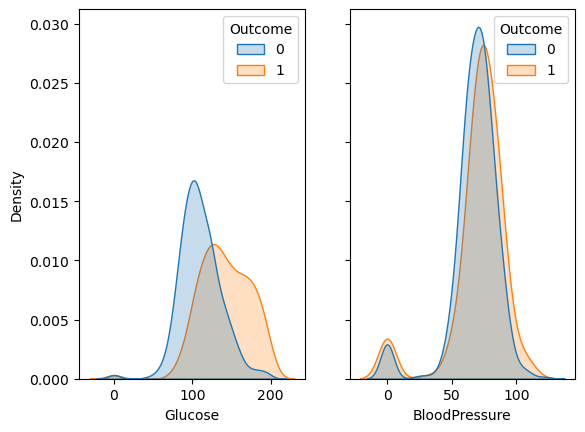

In [195]:

plt.figure(figsize=(6,3))

fig, plot_numbers = plt.subplots(nrows=1, ncols=2, sharey=True) #n_cols = 2 since we only want the probability density distribution of the least and most discriminative features

sns.kdeplot(data=data, x=data.columns.values[max_discriminative_power_feature_index], hue="Outcome", ax=plot_numbers[0], fill=True, common_norm=False)
sns.kdeplot(data=data, x=data.columns.values[min_discriminative_power_feature_index], hue="Outcome", ax=plot_numbers[1], fill=True, common_norm=False)

plt.show()


## 2 - Assess accuracy in different sample splits using Stratified cross validation

train/test = 80/20 means that 20% of all instances are used as test, and 80% as training data

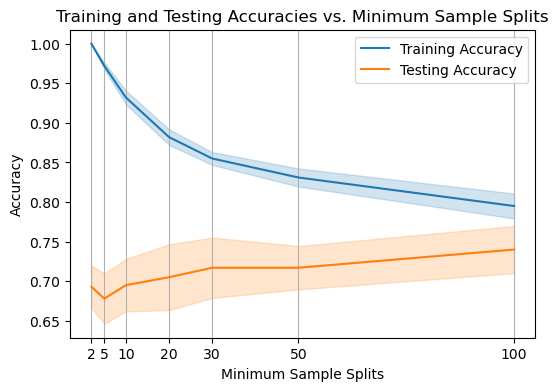

In [194]:
from sklearn import metrics, tree
from sklearn.model_selection import StratifiedShuffleSplit

min_sample_splits = [2,5,10,20,30,50,100] # number of samples required to split node (branch)
n_runs_for_average_out = 10


folds = StratifiedShuffleSplit(n_splits=n_runs_for_average_out, test_size=0.2, random_state=1) #By using a Shuffle Split, it averages out the random indexes suggested each parametrization, trying to lead to more deterministic results (since the seed is equal)

training_accuracies = []
testing_accuracies = []

#Per different minimum allowed sample splits
for min_sample_split in min_sample_splits:
    training_sample_accuracy = []
    testing_sample_accuracy = []
    
    # Per generated folds from averaged folds from 10 80-20 stratified splits

    for train_shuffle, test_shuffle in folds.split(X,y): #split according to fold
        
        #Extract Sample feature's matrix
        X_train = X.iloc[train_shuffle]
        X_test = X.iloc[test_shuffle]

        #Extract Sample's outcomes matrix
        y_train = y.iloc[train_shuffle]
        y_test = y.iloc[test_shuffle]

        #Create Tree classifier according to sample training data
        predictor = tree.DecisionTreeClassifier(min_samples_split=min_sample_split)
        predictor.fit(X_train,y_train)

        #Generate prediction according to test sample and measure accuracy
        y_pred_test = predictor.predict(X_test)
        testing_sample_accuracy.append(round(metrics.accuracy_score(y_test, y_pred_test),2))

        #Generate prediction according to training sample and measure accuracy
        y_pred_train = predictor.predict(X_train)
        training_sample_accuracy.append(round(metrics.accuracy_score(y_train, y_pred_train),2))

    # By using no mean here, we ensure a more accurate graph
    training_accuracies.append(training_sample_accuracy) 
    testing_accuracies.append(testing_sample_accuracy)


accuracy_df = pd.DataFrame({
    'min_sample_splits': min_sample_splits,
    'training_accuracies': training_accuracies,
    'testing_accuracies': testing_accuracies
})

accuracy_df = accuracy_df.explode("training_accuracies")
accuracy_df = accuracy_df.explode("testing_accuracies")

#TODO: change errorbar
plt.figure(figsize=(6,4))
sns.lineplot(data=accuracy_df, x="min_sample_splits", y="training_accuracies", label="Training Accuracy", errorbar="sd")
sns.lineplot(data=accuracy_df, x="min_sample_splits", y="testing_accuracies", label="Testing Accuracy", errorbar="sd")
plt.xlabel("Minimum Sample Splits")
plt.ylabel("Accuracy")
plt.title("Training and Testing Accuracies vs. Minimum Sample Splits")
plt.legend()
plt.xticks(min_sample_splits)
plt.grid(True, which='both', axis='x')
plt.show()


## 4 - Learn single decision tree predictor from the data

[Text(0.5, 0.875, 'Glucose <= 127.5\ngini = 0.454\nsamples = 768\nvalue = [500, 268]\nclass = 0'),
 Text(0.25, 0.625, 'Age <= 28.5\ngini = 0.313\nsamples = 485\nvalue = [391, 94]\nclass = 0'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'BMI <= 45.4\ngini = 0.155\nsamples = 271\nvalue = [248, 23]\nclass = 0'),
 Text(0.0625, 0.125, 'gini = 0.139\nsamples = 267\nvalue = [247, 20]\nclass = 0'),
 Text(0.1875, 0.125, 'gini = 0.375\nsamples = 4\nvalue = [1, 3]\nclass = 1'),
 Text(0.375, 0.375, 'BMI <= 26.35\ngini = 0.443\nsamples = 214\nvalue = [143, 71]\nclass = 0'),
 Text(0.3125, 0.125, 'gini = 0.093\nsamples = 41\nvalue = [39, 2]\nclass = 0'),
 Text(0.4375, 0.125, 'gini = 0.48\nsamples = 173\nvalue = [104, 69]\nclass = 0'),
 Text(0.75, 0.625, 'BMI <= 29.95\ngini = 0.474\nsamples = 283\nvalue = [109, 174]\nclass = 1'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'Glucose <= 145.5\ngini = 0.432\nsamples = 76\nvalue = [52, 24]\nclass = 0'),
 Text(0.5625, 0.125, 'gini = 0.25\nsam

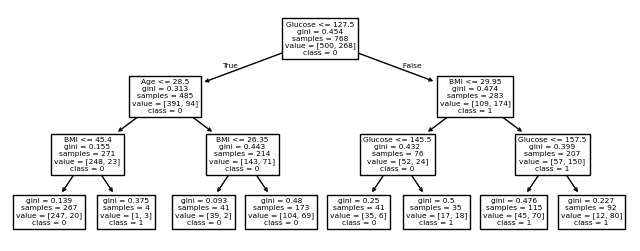

In [192]:
from sklearn import tree

predictor = tree.DecisionTreeClassifier(random_state=1,max_depth=3)
predictor.fit(X,y)

plt.figure(figsize=(8,3))
tree.plot_tree(predictor, feature_names=X.columns.values, class_names=[str(0),str(1)])

In [190]:
association_rules = tree.export_text(predictor, feature_names=X.columns.values, class_names=[str(0),str(1)])
print(association_rules)

|--- Glucose <= 127.50
|   |--- Age <= 28.50
|   |   |--- BMI <= 45.40
|   |   |   |--- class: 0
|   |   |--- BMI >  45.40
|   |   |   |--- class: 1
|   |--- Age >  28.50
|   |   |--- BMI <= 26.35
|   |   |   |--- class: 0
|   |   |--- BMI >  26.35
|   |   |   |--- class: 0
|--- Glucose >  127.50
|   |--- BMI <= 29.95
|   |   |--- Glucose <= 145.50
|   |   |   |--- class: 0
|   |   |--- Glucose >  145.50
|   |   |   |--- class: 1
|   |--- BMI >  29.95
|   |   |--- Glucose <= 157.50
|   |   |   |--- class: 1
|   |   |--- Glucose >  157.50
|   |   |   |--- class: 1



[Text(0.5, 0.875, 'Glucose <= 127.5\nsamples = 768\nvalue = [500, 268]\nclass = 0'),
 Text(0.25, 0.625, 'Age <= 28.5\nsamples = 485\nvalue = [391, 94]\nclass = 0'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'BMI <= 45.4\nsamples = 271\nvalue = [248, 23]\nclass = 0'),
 Text(0.0625, 0.125, 'samples = 267\nvalue = [247, 20]\nclass = 0'),
 Text(0.1875, 0.125, 'samples = 4\nvalue = [1, 3]\nclass = 1'),
 Text(0.375, 0.375, 'BMI <= 26.35\nsamples = 214\nvalue = [143, 71]\nclass = 0'),
 Text(0.3125, 0.125, 'samples = 41\nvalue = [39, 2]\nclass = 0'),
 Text(0.4375, 0.125, 'samples = 173\nvalue = [104, 69]\nclass = 0'),
 Text(0.75, 0.625, 'BMI <= 29.95\nsamples = 283\nvalue = [109, 174]\nclass = 1'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'Glucose <= 145.5\nsamples = 76\nvalue = [52, 24]\nclass = 0'),
 Text(0.5625, 0.125, 'samples = 41\nvalue = [35, 6]\nclass = 0'),
 Text(0.6875, 0.125, 'samples = 35\nvalue = [17, 18]\nclass = 1'),
 Text(0.875, 0.375, 'Glucose <= 157.5\nsampl

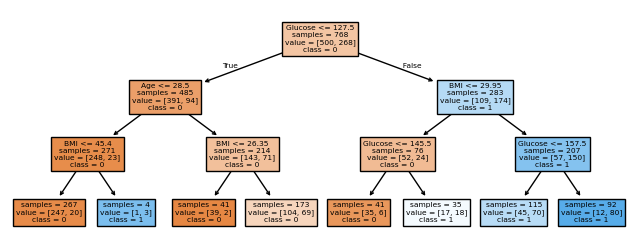

In [191]:
plt.figure(figsize=(8,3))
tree.plot_tree(predictor, feature_names=X.columns.values, class_names=[str(0),str(1)], filled=True, impurity=False)
# Add proportion=True for easier branch path probability